In [1]:
import polars as pl
import pandas as pd
import numpy as np
from enum import Enum
%matplotlib inline
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import pyarrow as pa
import random

csv_file = 'NIFTY 50_minute_data_with_indicators.csv'

def plot_graph(ArrayY, title, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.plot(ArrayY)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.show()

class Intervals:
    day = 375 #Day in minutes (Stock sells from 9:15 - 15:30)
    week = 1875 # 5 Days in minutes
    month = 7500 # 20 days of trading in month

from enum import Enum

class eTradingParam(Enum):
    CLOSE = "close"
    EMA_5 = "ema5"
    EMA_20 = "ema20"
    MACD_5_20 = "macd520"
    DATE = "date"
    DATE_ONLY = 'date_only'
    NEXT_5_MIN = 'next_5_min'
    

    

class Data:
    def __init__(self):
        self.filtered_data = pl.DataFrame()
        self.load_data(csv_file)
        
    def load_data(self, csv_file):
        self.filtered_data = pl.read_csv(csv_file)

    #dropping unnecessary data
    def drop_columns(self):
        self.filtered_data = self.filtered_data[[param.value for param in eTradingParam]]

    def plot_by_interval(self,interval_name, interval_value,eTradingParam:eTradingParam):
        title = f"{eTradingParam.name} {interval_name} Graph"
        tmp_data = data_instance.get_sample_data_by_minutes(interval_value)
        plot_graph(tmp_data[eTradingParam.value],title,f"{interval_value} minutes interval","Close Price")

    def set_sample_data_by_minutes(self, minutes):
        self.filtered_data = self.filtered_data[::minutes]

    def get_sample_data_by_minutes(self, minutes):
        return self.filtered_data[::minutes]
    
    #some of the days dont contains the whole values, in this situation remove them and print them
    def remove_corrupted_days_data(self, expected_count = Intervals.day):
        #first , create a filtering of a day instead of minute
        if self.filtered_data.schema[eTradingParam.DATE.value] == pl.Utf8:
            self.filtered_data = self.filtered_data.with_columns(pl.col(eTradingParam.DATE.value).str.strptime(pl.Datetime, format='%Y-%m-%d %H:%M:%S%z'))
        self.filtered_data = self.filtered_data.with_columns(pl.col(eTradingParam.DATE.value).dt.strftime('%Y-%m-%d').alias('date_only'))
        # group the data by the date part and count the number of minutes for each date
        grouped = self.filtered_data.group_by('date_only').len()
        # filter dates that do not have the expected count of rows
        valid_dates = grouped.filter(pl.col("len") == expected_count)['date_only']
        invalid_dates = grouped.filter(pl.col("len") != expected_count)['date_only']
        # Filter the original data to keep only the valid dates
        self.filtered_data = self.filtered_data.filter(pl.col('date_only').is_in(valid_dates))
        # print the invalid days that we remove
        print("Removed dates with incorrect minute counts:", invalid_dates.to_list())
        # Drop the helper 'date_only' column
        #self.filtered_data = self.filtered_data.drop('date_only')
    
    #adding results to each row to be the next row close column
    def adding_results_to_table(self):
        self.filtered_data = self.filtered_data.with_columns(pl.col('close').shift(-1).alias('next_5_min'))
        self.filtered_data.drop_nulls()
    
    #serch for invalid data/Empty and remove it
    def remove_nulls(self):
        self.filtered_data.drop_nulls()

    def clean_data(self):
        self.remove_nulls()
        self.remove_corrupted_days_data()
        
    #in our model we want to randomize sets with a day level, which means we are keep 24 hours clean from shuffle
    def split_train_test_validation(self, train_size = 0.7, validation_size =0.15):
        
        #get unique dates and shuffle them
        unique_dates = self.filtered_data.select(pl.col('date_only').unique()).to_series().to_list()
        random.shuffle(unique_dates)
        #calculate split indices
        total_days = len(unique_dates)
        train_size = int(total_days * train_size)
        val_size = int(total_days * validation_size)
        #split dates
        train_dates = unique_dates[:train_size]
        val_dates = unique_dates[train_size:train_size + val_size]
        test_dates = unique_dates[train_size + val_size:]
        #filter the data based on the split dates
        train_data = self.filtered_data.filter(pl.col('date_only').is_in(train_dates))
        val_data = self.filtered_data.filter(pl.col('date_only').is_in(val_dates))
        test_data = self.filtered_data.filter(pl.col('date_only').is_in(test_dates))
        return train_data, val_data, test_data

    @property
    def date(self):
        return self.filtered_data[eTradingParam.DATE.value].to_list()

    @property
    def close(self):
        return self.filtered_data[eTradingParam.CLOSE.value].to_list()

    @property
    def ema_5(self):
        return self.filtered_data[eTradingParam.EMA_5.value].to_list()

    @property
    def ema_20(self):
        return self.filtered_data[eTradingParam.EMA_20.value].to_list()

    @property
    def macd_5_20(self):
        return self.filtered_data[eTradingParam.MACD_5_20.value].to_list()

data_instance = Data()

KeyboardInterrupt: 

In [ ]:
#present the original data and clean the data
print(f"Our dataset contains the following parameters: {data_instance.filtered_data.columns}")
print(data_instance.filtered_data[:4])
print(f"the data start from date {min(data_instance.date)} - {max(data_instance.date)}, total {(len(data_instance.date)/Intervals.day)} days (not integer because we had days that are not fully detaild that we are going to remove )")

#clean the half days and clean nulls
print('lets add column that will represnt the y(the data that should predicted) that is the close of the stock more 5 minutes')
print("\neach day should start at 9:15 and finished at 15:30")
print("lets remove not fully detailed days and also days that contains empty values")
data_instance.clean_data()
print(f"so after clear we have in total {(len(data_instance.date)/Intervals.day)} days")


Our dataset contains the following parameters: ['date', 'close', 'high', 'low', 'open', 'volume', 'sma5', 'sma10', 'sma15', 'sma20', 'ema5', 'ema10', 'ema15', 'ema20', 'upperband', 'middleband', 'lowerband', 'HT_TRENDLINE', 'KAMA10', 'KAMA20', 'KAMA30', 'SAR', 'TRIMA5', 'TRIMA10', 'TRIMA20', 'ADX5', 'ADX10', 'ADX20', 'APO', 'CCI5', 'CCI10', 'CCI15', 'macd510', 'macd520', 'macd1020', 'macd1520', 'macd1226', 'MFI', 'MOM10', 'MOM15', 'MOM20', 'ROC5', 'ROC10', 'ROC20', 'PPO', 'RSI14', 'RSI8', 'slowk', 'slowd', 'fastk', 'fastd', 'fastksr', 'fastdsr', 'ULTOSC', 'WILLR', 'ATR', 'Trange', 'TYPPRICE', 'HT_DCPERIOD', 'BETA']
shape: (4, 60)
┌────────────────┬─────────┬─────────┬─────────┬───┬────────┬─────────────┬─────────────┬──────────┐
│ date           ┆ close   ┆ high    ┆ low     ┆ … ┆ Trange ┆ TYPPRICE    ┆ HT_DCPERIOD ┆ BETA     │
│ ---            ┆ ---     ┆ ---     ┆ ---     ┆   ┆ ---    ┆ ---         ┆ ---         ┆ ---      │
│ str            ┆ f64     ┆ f64     ┆ f64     ┆   ┆ f64   

In [ ]:
data_instance.drop_columns()
print(f"After researching extensively on the web and exploring about algorithmic trading principles, we have chosen to proceed with the following parameters: {data_instance.filtered_data.columns}")
print(data_instance.filtered_data[:10])


After researching extensively on the web and exploring about algorithmic trading principles, we have chosen to proceed with the following parameters: ['close', 'ema5', 'ema20', 'macd520', 'date_only', 'next_5_min']
shape: (4, 6)
┌─────────┬─────────────┬─────────────┬────────────┬────────────┬────────────┐
│ close   ┆ ema5        ┆ ema20       ┆ macd520    ┆ date_only  ┆ next_5_min │
│ ---     ┆ ---         ┆ ---         ┆ ---        ┆ ---        ┆ ---        │
│ f64     ┆ f64         ┆ f64         ┆ f64        ┆ str        ┆ f64        │
╞═════════╪═════════════╪═════════════╪════════════╪════════════╪════════════╡
│ 8253.1  ┆ 8272.152126 ┆ 8279.383314 ┆ -7.231188  ┆ 2015-01-12 ┆ 8253.7     │
│ 8253.7  ┆ 8266.001418 ┆ 8276.937284 ┆ -10.935867 ┆ 2015-01-12 ┆ 8257.85    │
│ 8257.85 ┆ 8263.284278 ┆ 8275.119448 ┆ -11.835169 ┆ 2015-01-12 ┆ 8262.4     │
│ 8262.4  ┆ 8262.989519 ┆ 8273.908072 ┆ -10.918553 ┆ 2015-01-12 ┆ 8267.6     │
└─────────┴─────────────┴─────────────┴────────────┴────────

In [ ]:
#Here are some report on the filtered data
#convert to pandas just for report
table_pd = pd.DataFrame(data_instance.filtered_data)
table_pd.columns = data_instance.filtered_data.columns
data_report = ProfileReport(table_pd)
data_report

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


We can see that the biger resolution, the smoother graph
This happens because the smaller resoution includes in it more changes


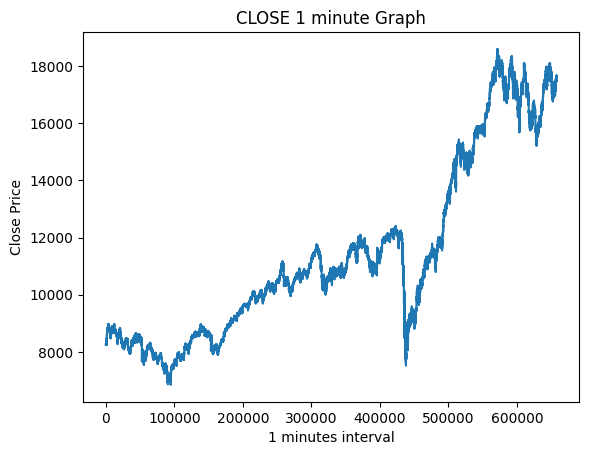

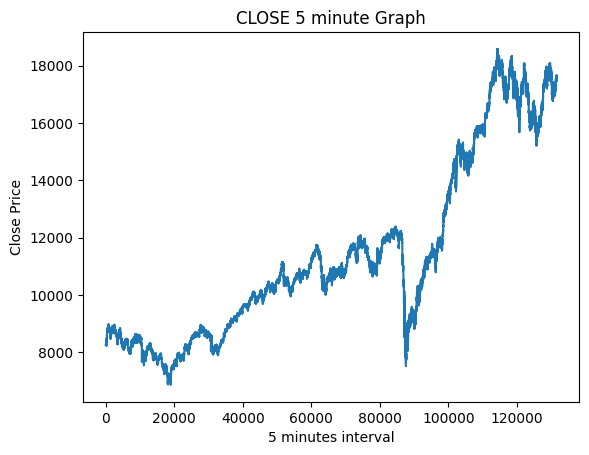

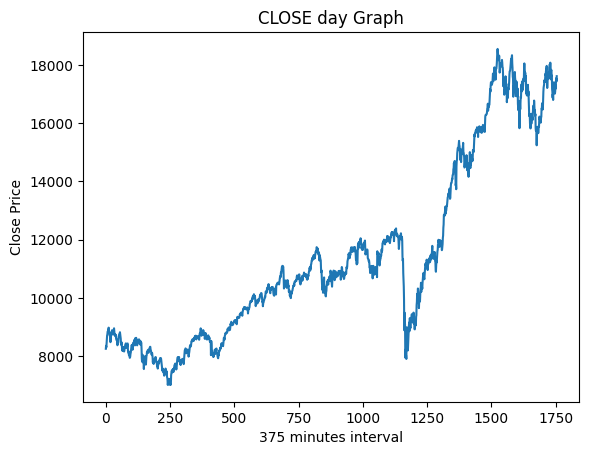

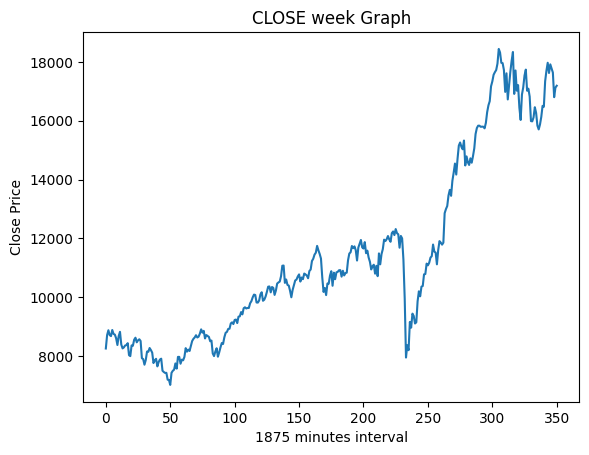

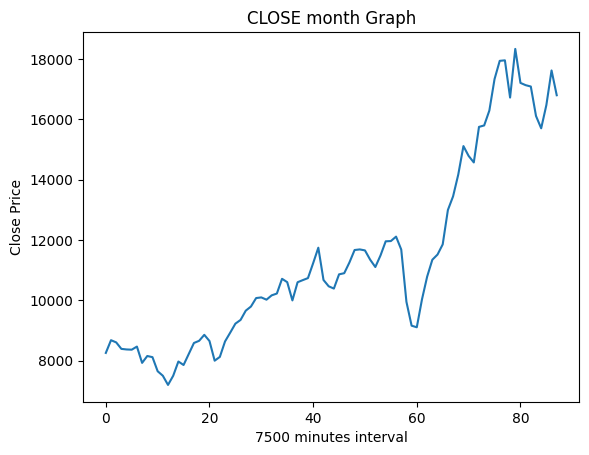

In [ ]:
print("We can see that the biger resolution, the smoother graph")
print("This happens because the smaller resoution includes in it more changes")
data_instance.plot_by_interval('1 minute',1,eTradingParam.CLOSE)
data_instance.plot_by_interval('5 minute',5,eTradingParam.CLOSE)
data_instance.plot_by_interval('day',Intervals.day,eTradingParam.CLOSE)
data_instance.plot_by_interval('week',Intervals.week,eTradingParam.CLOSE)
data_instance.plot_by_interval('month',Intervals.month,eTradingParam.CLOSE)


In [ ]:
print("What we can figure out is that using 1 minute data will be very noisy and will be more hard to predict.\nWe have to remember that also the interval it's trade of noise and potential profit, The lower interval is noisy and higher profit, the higher interval is more smooth and less potential profit.\nWe will go on 5 minutes intervals. ")
deviation_by_5 = 5
data_instance.set_sample_data_by_minutes(deviation_by_5)
data_instance.adding_results_to_table()
#now the number of samples at day is devided by 5
Intervals.day /= deviation_by_5
Intervals.week /= deviation_by_5
Intervals.month /= deviation_by_5



What we can figure out is that using 1 minute data will be very noisy and will be more hard to predict.
We have to remember that also the interval it's trade of noise and potential profit, The lower interval is noisy and higher profit, the higher interval is more smooth and less potential profit.
We will go on 5 minutes intervals. 


In [ ]:
train_data, val_data, test_data = data_instance.split_train_test_validation() #train 0.7 , val 0.15, test 0.15
print("after splitting the days what we got is : ")
print(f"example of train data:\n {train_data[:10]}\n total days {(len(train_data)/Intervals.day)}")
print(f"example of validation data:\n {val_data[:10]}\n total days {(len(val_data)/Intervals.day)}")
print(f"example of test data:\n {test_data[:10]}\n total days {(len(test_data)/Intervals.day)}")
print("now we will save it to excels and will be used later by model")
train_data.write_csv('train_data.csv')
val_data.write_csv('val_data.csv')
test_data.write_csv('test_data.csv')


after splitting the days what we got is : 
example of train data:
 shape: (10, 6)
┌─────────┬─────────────┬─────────────┬───────────┬────────────┬────────────┐
│ close   ┆ ema5        ┆ ema20       ┆ macd520   ┆ date_only  ┆ next_5_min │
│ ---     ┆ ---         ┆ ---         ┆ ---       ┆ ---        ┆ ---        │
│ f64     ┆ f64         ┆ f64         ┆ f64       ┆ str        ┆ f64        │
╞═════════╪═════════════╪═════════════╪═══════════╪════════════╪════════════╡
│ 8253.1  ┆ 8272.152126 ┆ 8279.383314 ┆ -7.231188 ┆ 2015-01-12 ┆ 8253.7     │
│ 8267.45 ┆ 8265.500897 ┆ 8272.749465 ┆ -7.248567 ┆ 2015-01-12 ┆ 8269.5     │
│ 8257.65 ┆ 8262.352999 ┆ 8269.375225 ┆ -7.022226 ┆ 2015-01-12 ┆ 8255.9     │
│ 8262.35 ┆ 8263.430642 ┆ 8266.929456 ┆ -3.498814 ┆ 2015-01-12 ┆ 8258.1     │
│ 8263.85 ┆ 8262.305064 ┆ 8264.754347 ┆ -2.449283 ┆ 2015-01-12 ┆ 8261.4     │
│ 8259.35 ┆ 8259.744494 ┆ 8262.837522 ┆ -3.093028 ┆ 2015-01-12 ┆ 8262.55    │
│ 8271.7  ┆ 8268.137958 ┆ 8264.929443 ┆ 3.208515  ┆ 2015-01-